In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers,models

In [2]:
# Defining Regularized loss function
def regloss(y_pred,y,w1,w2=0):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    loss=(1/(batch_size))*(np.square(y-y_pred)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [3]:
# Defining accuracy function
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    #acc=1-(1/(batch_size))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [5]:
# Importing data set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

K = len(np.unique(y_train)) # Classes #np.unique Find the unique elements of an array.
Ntr = x_train.shape[0] # Number of training data
Nte = x_test.shape[0] # Number of testing data
Din = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] # CIFAR10

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Centering pixel values
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# One hot encoding the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#flatterning the input images and changing the data type
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)


# Linear Classifier

In [9]:
# Defining linear Classifier function

def linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0] # Number of training data
    Nte = x_test.shape[0] # Number of testing data

    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    # Initializing weight and bias arrays
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    for t in range(iterations):
        # shuffling the training data set to randomize the training process.To prevent overfitting
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        # forward pass
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1

        # calculating loss
        train_loss=regloss(y_pred,y,w1)
        test_loss=regloss(y_pred_test,y_test,w1)
        loss_history.append(train_loss)
        loss_history_test.append(test_loss)
        
        # calculating accuracy
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: loss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)

        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history

In [10]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda
w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history=linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

epoch 0/300: loss= 0.999977-- ,test loss= 0.999973--,train accracy= 0.681550--, test accracy= 0.681780
epoch 10/300: loss= 0.876637-- ,test loss= 0.876236--,train accracy= 0.756426--, test accracy= 0.758020
epoch 20/300: loss= 0.842541-- ,test loss= 0.842417--,train accracy= 0.762644--, test accracy= 0.767820
epoch 30/300: loss= 0.823617-- ,test loss= 0.823715--,train accracy= 0.766510--, test accracy= 0.770480
epoch 40/300: loss= 0.812389-- ,test loss= 0.812707--,train accracy= 0.768606--, test accracy= 0.771610
epoch 50/300: loss= 0.805426-- ,test loss= 0.805970--,train accracy= 0.770424--, test accracy= 0.772820
epoch 60/300: loss= 0.800906-- ,test loss= 0.801679--,train accracy= 0.771590--, test accracy= 0.773650
epoch 70/300: loss= 0.797822-- ,test loss= 0.798824--,train accracy= 0.772696--, test accracy= 0.773580
epoch 80/300: loss= 0.795605-- ,test loss= 0.796835--,train accracy= 0.773772--, test accracy= 0.774410
epoch 90/300: loss= 0.793930-- ,test loss= 0.795381--,train accra

In [38]:
def graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,name):
    lists=[loss_history,loss_history_test,train_acc_history,val_acc_history]
    titiles=["training loss","testing loss","training accuracy","testing accuracy"]
    fig,ax=plt.subplots(1,4,figsize=(25,5))
    for i in range(len(lists)):
        ax[i].plot(lists[i])
        ax[i].set_ylabel(titiles[i])
        ax[i].set_xlabel("epoch")
        ax[i].plot()
    fig.savefig(fname="metrics_"+name+".png",transparent=True)
    return True

True

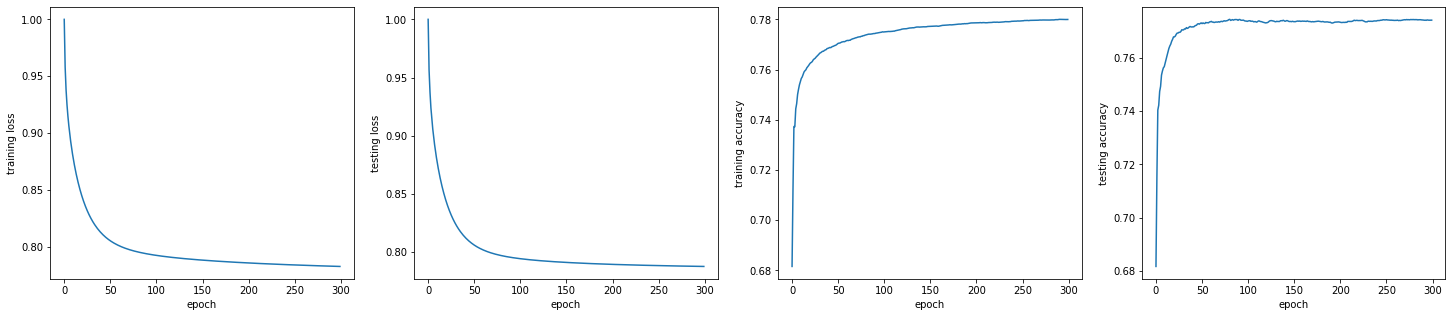

In [39]:
graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,"linear classifier")

In [64]:
images=[]
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w1.shape[1]):
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].xticks()
        ax[i,j].yticks()
        ax[i,j].titles(titles[i*5+j])
plt.show()

# 2 Layer Dense Network

In [28]:
def layer2(x_train,y_train,x_test,y_test,batch_size,H,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-5
    w1 = (2/(Ntr*Din))**0.5*np.random.randn(Din, H)
    w2 = (2/(H*Din))**0.5*np.random.randn(H, K)
    b1 = np.zeros(H)
    b2 = np.zeros(K)

    for t in range(iterations):
        indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(indices)
        x=x_train[indices]*255
        #x=x_train[indices]
        y=y_train[indices]

        #forward pass
        h=1/(1+np.exp(-(x.dot(w1)+b1)))
        h_test=1/(1+np.exp(-((x_test*255).dot(w1)+b1)))
        #h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))

        y_pred=h.dot(w2)+b2
        y_pred_test=h_test.dot(w2)+b2


        train_loss=regloss(y_pred,y,w1,w2)
        test_loss=regloss(y_pred_test,y_test,w1,w2)
        #loss=(1/batch_size)*np.sum(np.square(y_train-y_pred),axis=0)+reg*np.sum(w1*w1)
        loss_history.append(train_loss)
        
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2=h.T.dot(dy_pred)+reg*w2
        db2=dy_pred.sum(axis=0)
        dh=dy_pred.dot(w2.T)
        dw1=x.T.dot(dh*h*(1-h))+reg*w1
        db1=(dh*h*(1-h)).sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        w2-=lr*dw2
        b2-=lr*db2
        lr*=lr_decay
    return w1,b1,w2,b2,loss_history,train_acc_history,val_acc_history

In [20]:
batch_size = Ntr
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda

w1n,b1n,w2n,b2n,loss_historyn,train_acc_historyn,val_acc_historyn=layer2(x_train,y_train,x_test,y_test,batch_size,H,K,Din,lr,lr_decay,reg)

epoch 0/300: MSloss= 1.004406-- ,test loss= 1.004210--,train accracy= 0.724932--, test accracy= 0.726500
epoch 10/300: MSloss= 0.840163-- ,test loss= 0.840274--,train accracy= 0.745548--, test accracy= 0.745080
epoch 20/300: MSloss= 0.812083-- ,test loss= 0.813255--,train accracy= 0.757598--, test accracy= 0.760670
epoch 30/300: MSloss= 0.810219-- ,test loss= 0.810916--,train accracy= 0.762030--, test accracy= 0.759240
epoch 40/300: MSloss= 0.792762-- ,test loss= 0.795778--,train accracy= 0.769976--, test accracy= 0.770290
epoch 50/300: MSloss= 0.789173-- ,test loss= 0.791866--,train accracy= 0.776198--, test accracy= 0.770650
epoch 60/300: MSloss= 0.783353-- ,test loss= 0.787202--,train accracy= 0.777622--, test accracy= 0.777740
epoch 70/300: MSloss= 0.778460-- ,test loss= 0.783309--,train accracy= 0.774162--, test accracy= 0.771500
epoch 80/300: MSloss= 0.785924-- ,test loss= 0.793366--,train accracy= 0.775348--, test accracy= 0.769670
epoch 90/300: MSloss= 0.777128-- ,test loss= 0.

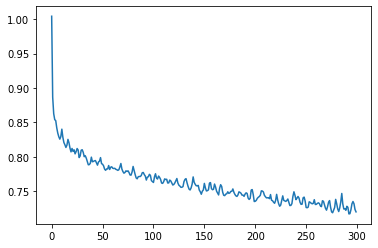

In [21]:
x_axis=np.arange(len(loss_historyn))
plt.plot(x_axis,loss_historyn)

# With batching

In [32]:
batch_size = 500
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda

w1m,b1m,w2m,b2m,loss_historym,train_acc_historym,val_acc_historym=layer2(x_train,y_train,x_test,y_test,batch_size,H,K,Din,lr,lr_decay,reg)

epoch 0/300: MSloss= 1.013486-- ,test loss= 1.015386--,train accracy= 0.695600--, test accracy= 0.688790
epoch 10/300: MSloss= 0.834908-- ,test loss= 0.833713--,train accracy= 0.764200--, test accracy= 0.755350
epoch 20/300: MSloss= 0.818700-- ,test loss= 0.823888--,train accracy= 0.748000--, test accracy= 0.744560
epoch 30/300: MSloss= 0.816595-- ,test loss= 0.808949--,train accracy= 0.756000--, test accracy= 0.761920
epoch 40/300: MSloss= 0.822154-- ,test loss= 0.806496--,train accracy= 0.723600--, test accracy= 0.752280
epoch 50/300: MSloss= 0.812619-- ,test loss= 0.806683--,train accracy= 0.748600--, test accracy= 0.750970
epoch 60/300: MSloss= 0.807908-- ,test loss= 0.799975--,train accracy= 0.749800--, test accracy= 0.763660
epoch 70/300: MSloss= 0.785214-- ,test loss= 0.789528--,train accracy= 0.769600--, test accracy= 0.774460
epoch 80/300: MSloss= 0.793972-- ,test loss= 0.789151--,train accracy= 0.765200--, test accracy= 0.776450
epoch 90/300: MSloss= 0.788431-- ,test loss= 0.

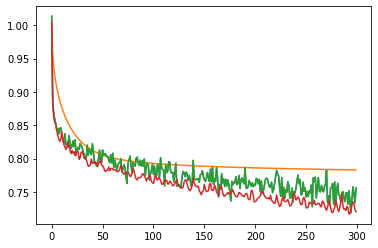

In [37]:
plt.plot(x_axis,loss_historym)
plt.plot(x_axis,loss_history)
plt.plot(x_axis,loss_historym)
plt.plot(x_axis,loss_historyn)

# CNN

In [45]:
from tensorflow.keras import layers,models

In [60]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

K = len(np.unique(y_train)) # Classes #np.unique Find the unique elements of an array.
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] # CIFAR10

# Normalize pixel values
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)


In [63]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
model.fit(x_train,y_train,epochs=60,batch_size=50)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)             

In [ ]:
+